In [29]:
#Technical Indicators
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
from ta.volatility import KeltnerChannel
from ta.momentum import ROCIndicator

# Plotting
import matplotlib.pyplot as plt

#Getting data
import yfinance as yf
import math
import pandas as pd
import numpy as np

In [30]:
meta = 'META'
amazon = "AMZN"
apple = "AAPL"
netflix = 'NFLX'
google = 'GOOGL'

stockList = {meta : {}, amazon: {}, apple: {}, netflix: {}, google: {}}
stockData = {}
weight = 0.2

start = '2015-01-01'
end = '2019-12-31'

Text(0.5, 1.0, "MAANG Stocks' Close Price from 2015-2019")

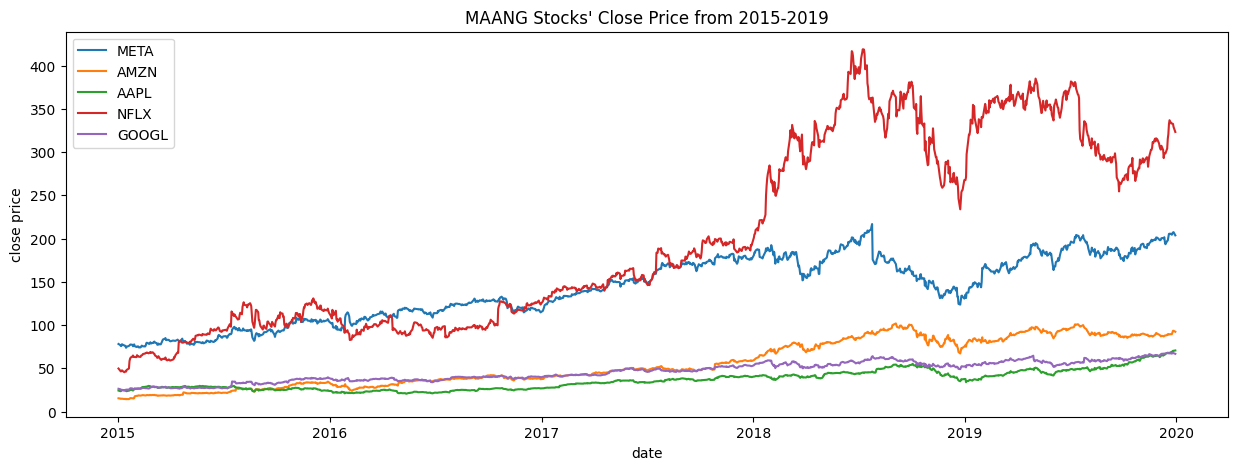

In [31]:
fig = plt.figure(figsize=(15, 5))
for stock in stockList.keys():
	hist_stock = yf.Ticker(stock).history(start = start, end = end)
	stockList[stock]['info'] = hist_stock
	plt.plot(hist_stock.index, hist_stock['Close'], label=f"{stock}")
	plt.legend()

plt.xlabel('date')
plt.ylabel('close price')
plt.title(f'MAANG Stocks\' Close Price from 2015-2019')

**Momentum Strategy: MACD + EMA(200)**

*MACD indicator computation: MACD = EMA(12) - EMA(26) and MACD signal line = EMA(9) of MACD line*

Buy signal:
- MACD crosses above signal line, AND
- Stock price crosses above EMA(200)

Sell signal:
- MACD crosses below signal line, AND
- Stock price crosses below EMA(200)

In [47]:
data = pd.DataFrame()

def download_data(stock, start_date, end_date):
    """Download stock data."""
    data['Close'] = yf.download(stock, start=start_date, end=end_date, progress=False)['Close']
    return data

### Indicators calculation and signal generation functions 

def calculate_indicators(data):
    """Calculate the 200-day EMA and MACD indicators."""
    data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

    exp12 = data['Close'].ewm(span=12, adjust=False).mean()
    exp26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp12 - exp26
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

def generate_signals(data):
    """Generate buy and sell signals based on MACD and 200-day EMA."""
    data['Position'] = 0  # 1 for long signal, -1 for short signal

    for i in range(1, len(data)):

        T_minus_one = data.index[i-1]
        T_day = data.index[i]

        if (data.loc[T_day, 'Close'] > data.loc[T_day, 'EMA_200']) and (data.loc[T_day, 'MACD'] > data.loc[T_day, 'Signal_Line']) and (data.loc[T_minus_one, 'MACD'] <= data.loc[T_minus_one, 'Signal_Line']):
            data.loc[T_day, 'Position'] = 1  # Long signal
        elif (data.loc[T_day, 'Close'] < data.loc[T_day, 'EMA_200']) and (data.loc[T_day, 'MACD'] < data.loc[T_day, 'Signal_Line']) and (data.loc[T_minus_one, 'MACD'] >= data.loc[T_minus_one, 'Signal_Line']):
            data.loc[T_day, 'Position'] = -1  # Short signal
        else:
            data.loc[T_day, 'Position'] = data.loc[T_minus_one, 'Position']
            # data['Position'].iloc[i] = data['Position'].iloc[i-1]

### Strategy and benchmark returns calculation functions

def calculate_benchmark_returns(data, start_date, end_date):
    """Calculates cumulative returns of an equal-weighted MAANG portfolio."""
    tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
    benchmark_data = yf.download(tickers, start=start_date, end=end_date)['Close']
    daily_returns = benchmark_data.pct_change()
    equal_weight = 1 / len(tickers)
    equal_weighted_returns = daily_returns.dot([equal_weight] * len(tickers))
    cumulative_returns = (1 + equal_weighted_returns).cumprod() - 1
    cumulative_returns.index = cumulative_returns.index.date
    data['Benchmark_Cumulative_Returns'] = cumulative_returns.loc[data.index]

def calculate_returns(data):
    """Calculate strategy and market returns."""
    data['Stock_Return'] = data['Close'].pct_change()
    data['Strategy_Return'] = data['Position'].shift(1) * data['Stock_Return']
    data['Cumulative_Strategy_Return'] = (data['Strategy_Return'] + 1).cumprod() - 1

def final_cumulative_return(data):
    """Calculate the final cumulative return of the strategy."""
    return data['Cumulative_Strategy_Return'].iloc[-1]

### Performance metrics functions

def sharpe_ratio(data, risk_free_rate=0.0):
    """Calculate the Sharpe ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    return np.sqrt(252) * excess_return.mean() / excess_return.std()

def sortino_ratio(data, risk_free_rate=0.0):
    """Calculate the Sortino ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    negative_return = data['Strategy_Return'][data['Strategy_Return'] < 0]
    downside_deviation = np.std(negative_return) * np.sqrt(252)
    return (excess_return.mean() * 252) / downside_deviation

def treynor_ratio(data, beta, risk_free_rate=0.0):
    """Calculate the Treynor ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    return (excess_return.mean() * 252) / beta

def tracking_error(data):
    """Calculate the tracking error of the strategy vs. the benchmark."""
    active_return = data['Strategy_Return'] - data['Stock_Return']
    return np.std(active_return) * np.sqrt(252)

def information_ratio(data):
    """Calculate the information ratio of the strategy vs. the benchmark."""
    active_return = data['Strategy_Return'] - data['Stock_Return']
    return (active_return.mean() * 252) / tracking_error(data)

def max_drawdown(data):
    """Calculate the maximum drawdown of the strategy."""
    cumulative = (data['Strategy_Return'] + 1).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

### Plotting and summary functions

def visualize_signals(data, stock):
    """Plot price, 200-day EMA, and buy/sell signals."""
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price', color='black', alpha=0.5)
    plt.plot(data['EMA_200'], label='200-day EMA', color='blue')

    buy_signals = data[(data['Position'] == 1) & (data['Position'].shift(1) != 1)]
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100)

    sell_signals = data[(data['Position'] == -1) & (data['Position'].shift(1) != -1)]
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100)

    plt.title(f'{stock} Price with 200-day EMA and MACD Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

def plot_cumulative_returns(data, stock, start_date, end_date):
    """Plot cumulative returns of the strategy vs. benchmark."""
    calculate_benchmark_returns(data, start_date, end_date)

    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Cumulative_Strategy_Return'], label='Strategy Return')
    plt.plot(data.index, data['Benchmark_Cumulative_Returns'], label='Equal-Weighted MAANG Portfolio', linestyle='--')

    plt.title(f'{stock} Strategy Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()

def summary(stock, data, performance_metrics):
    """Print a summary of performance metrics."""
    print(f"Performance Summary for {stock}:")
    for metric, value in performance_metrics.items():
        print(f"{metric}: {value:.2%}")

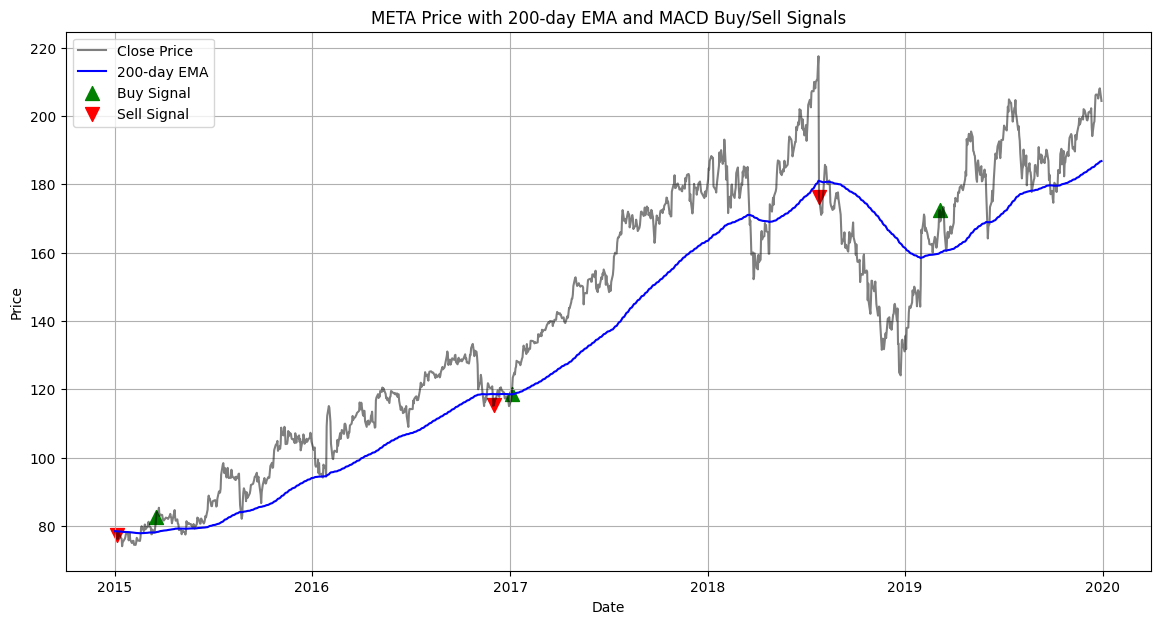

[*********************100%***********************]  5 of 5 completed


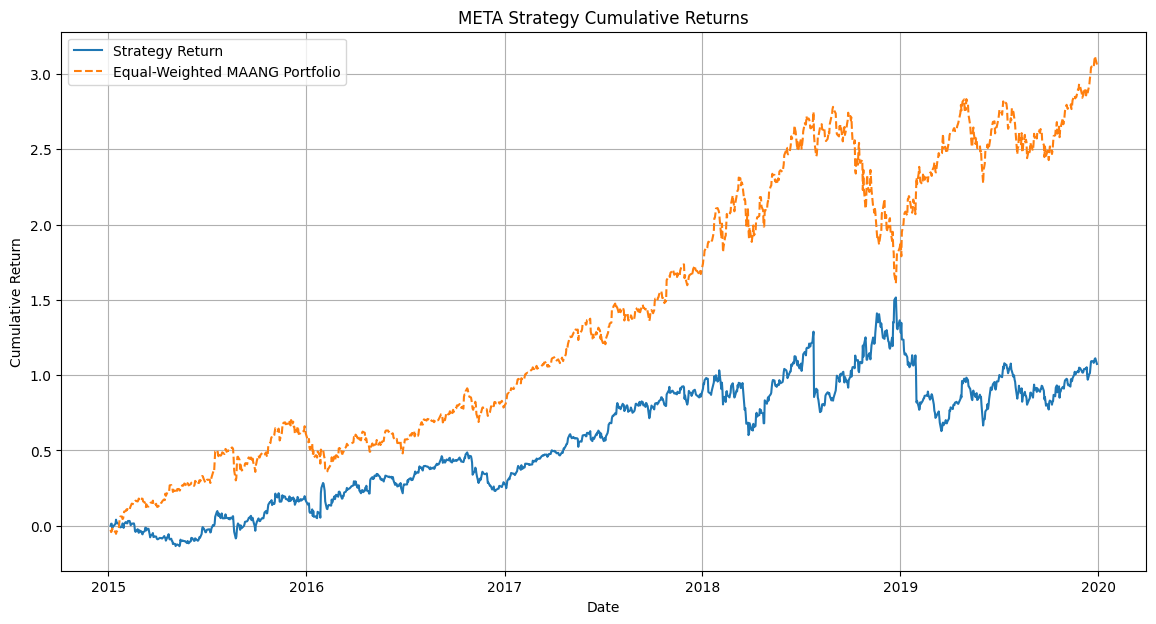

Performance Summary for META:
Cumulative Strategy Return: 107.41%
Sharpe Ratio: 66.12%
Sortino Ratio: 81.58%
Treynor Ratio: 15.56%
Max Drawdown: -35.27%
Tracking Error: 27.16%
Information Ratio: -16.80%

=== Data for META ===


,Close,EMA_200,MACD,Signal_Line,Position,Stock_Return,Strategy_Return,Cumulative_Strategy_Return,Benchmark_Cumulative_Returns
Date,,,,,,,,,
2015-01-02,78.449997,78.449997,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,77.190002,78.437460,-0.100512,-0.020102,-1,-0.016061,-0.000000,0.000000,-0.026940
2015-01-06,76.150002,78.414699,-0.261079,-0.068298,-1,-0.013473,0.013473,0.013473,-0.042122
2015-01-07,76.150002,78.392165,-0.383904,-0.131419,-1,0.000000,-0.000000,0.013473,-0.036974
2015-01-08,78.180000,78.390054,-0.313822,-0.167900,-1,0.026658,-0.026658,-0.013544,-0.018178
...,...,...,...,...,...,...,...,...,...
2019-12-23,206.179993,186.006692,2.527639,2.116499,1,-0.000582,-0.000582,1.092051,3.053787
2019-12-24,205.119995,186.196874,2.595922,2.212383,1,-0.005141,-0.005141,1.081295,3.045198
2019-12-26,207.789993,186.411731,2.832828,2.336472,1,0.013017,0.013017,1.108387,3.117227


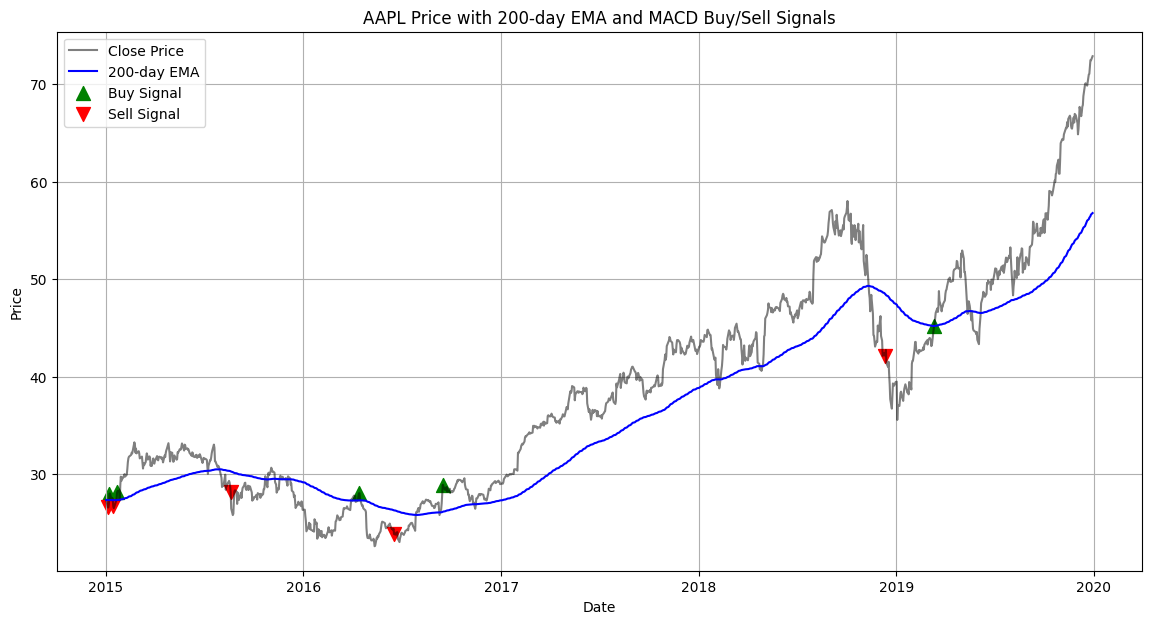

[*********************100%***********************]  5 of 5 completed


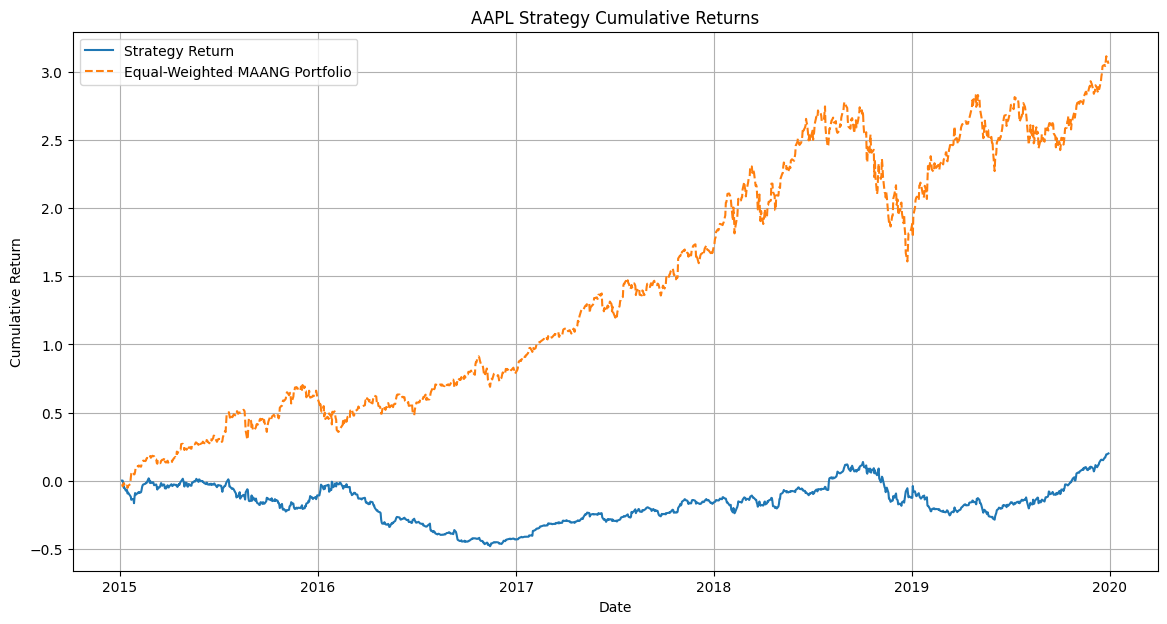

Performance Summary for AAPL:
Cumulative Strategy Return: 19.93%
Sharpe Ratio: 27.11%
Sortino Ratio: 36.72%
Treynor Ratio: 5.62%
Max Drawdown: -49.05%
Tracking Error: 29.22%
Information Ratio: -54.89%

=== Data for AAPL ===


,Close,EMA_200,MACD,Signal_Line,Position,Stock_Return,Strategy_Return,Cumulative_Strategy_Return,Benchmark_Cumulative_Returns
Date,,,,,,,,,
2015-01-02,27.332500,27.332500,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,26.562500,27.324839,-0.061425,-0.012285,-1,-0.028172,-0.000000,0.000000,-0.026940
2015-01-06,26.565001,27.317278,-0.108650,-0.031558,-1,0.000094,-0.000094,-0.000094,-0.042122
2015-01-07,26.937500,27.313499,-0.114696,-0.048186,-1,0.014022,-0.014022,-0.014115,-0.036974
2015-01-08,27.972500,27.320057,-0.035562,-0.045661,1,0.038422,-0.038422,-0.051995,-0.018178
...,...,...,...,...,...,...,...,...,...
2019-12-23,71.000000,56.152818,1.616619,1.462688,1,0.016318,0.016318,0.168365,3.053787
2019-12-24,71.067497,56.301223,1.656653,1.501481,1,0.000951,0.000951,0.169476,3.045198
2019-12-26,72.477501,56.462181,1.781618,1.557508,1,0.019840,0.019840,0.192679,3.117227


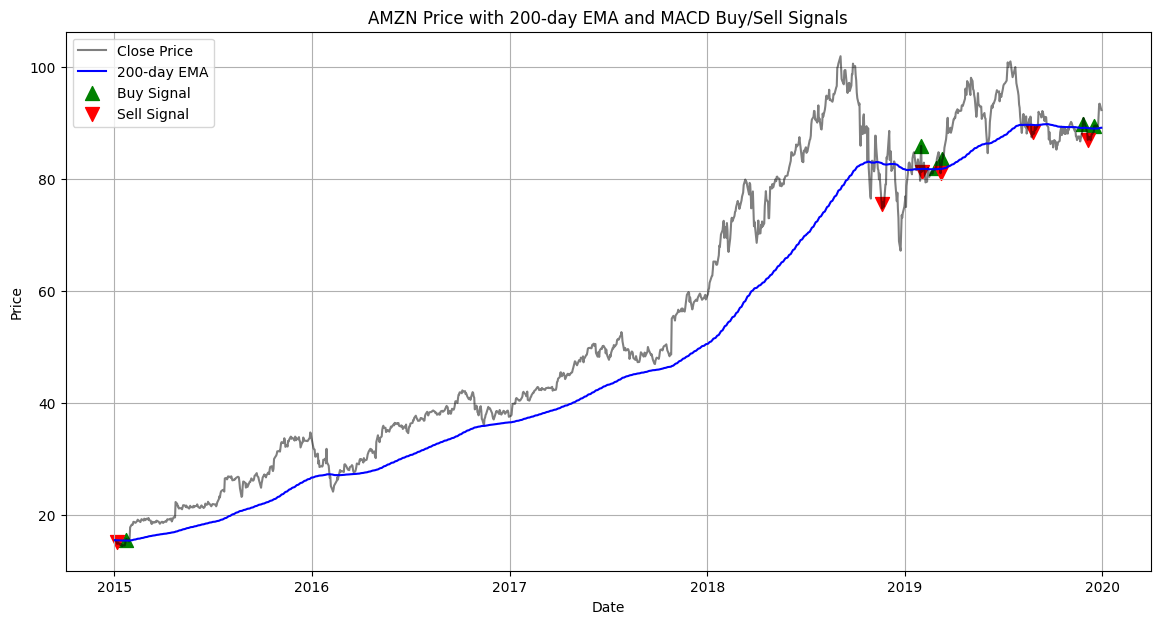

[*********************100%***********************]  5 of 5 completed


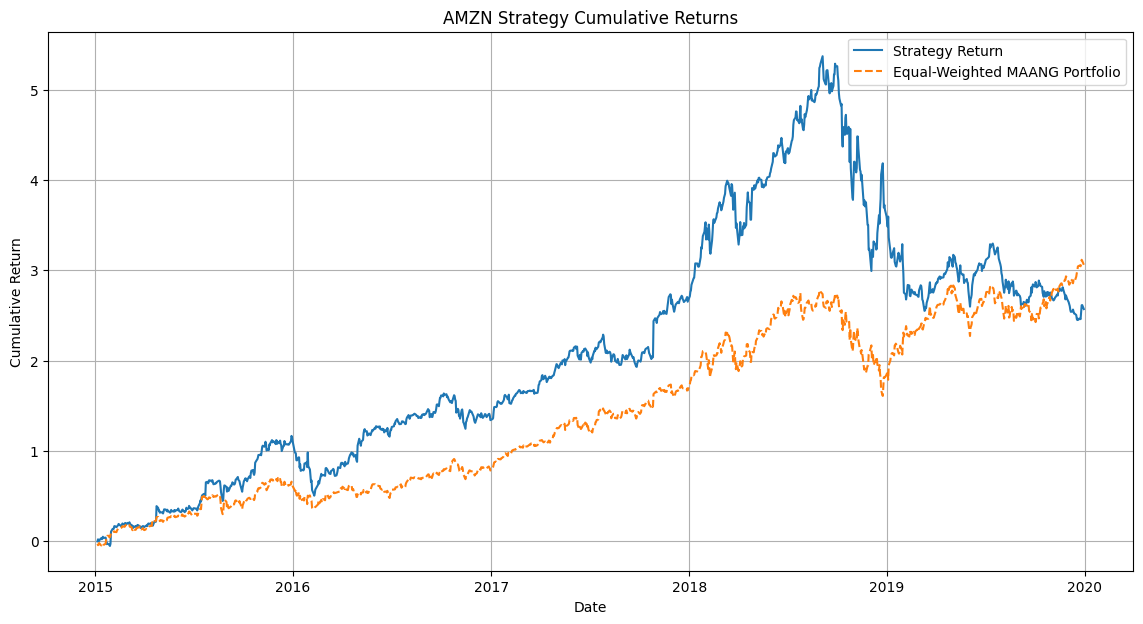

Performance Summary for AMZN:
Cumulative Strategy Return: 257.15%
Sharpe Ratio: 101.73%
Sortino Ratio: 144.69%
Treynor Ratio: 24.83%
Max Drawdown: -45.85%
Tracking Error: 22.14%
Information Ratio: -46.75%

=== Data for AMZN ===


,Close,EMA_200,MACD,Signal_Line,Position,Stock_Return,Strategy_Return,Cumulative_Strategy_Return,Benchmark_Cumulative_Returns
Date,,,,,,,,,
2015-01-02,15.426000,15.426000,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,15.109500,15.422850,-0.025248,-0.005050,-1,-0.020517,-0.000000,0.000000,-0.026940
2015-01-06,14.764500,15.416300,-0.072263,-0.018492,-1,-0.022833,0.022833,0.022833,-0.042122
2015-01-07,14.921000,15.411371,-0.095790,-0.033952,-1,0.010600,-0.010600,0.011992,-0.036974
2015-01-08,15.023000,15.407507,-0.104994,-0.048160,-1,0.006836,-0.006836,0.005074,-0.018178
...,...,...,...,...,...,...,...,...,...
2019-12-23,89.650002,89.058414,0.254335,0.053648,1,0.003638,0.003638,2.467262,3.053787
2019-12-24,89.460503,89.062415,0.284445,0.099808,1,-0.002114,-0.002114,2.459933,3.045198
2019-12-26,93.438499,89.105958,0.622128,0.204272,1,0.044467,0.044467,2.613784,3.117227


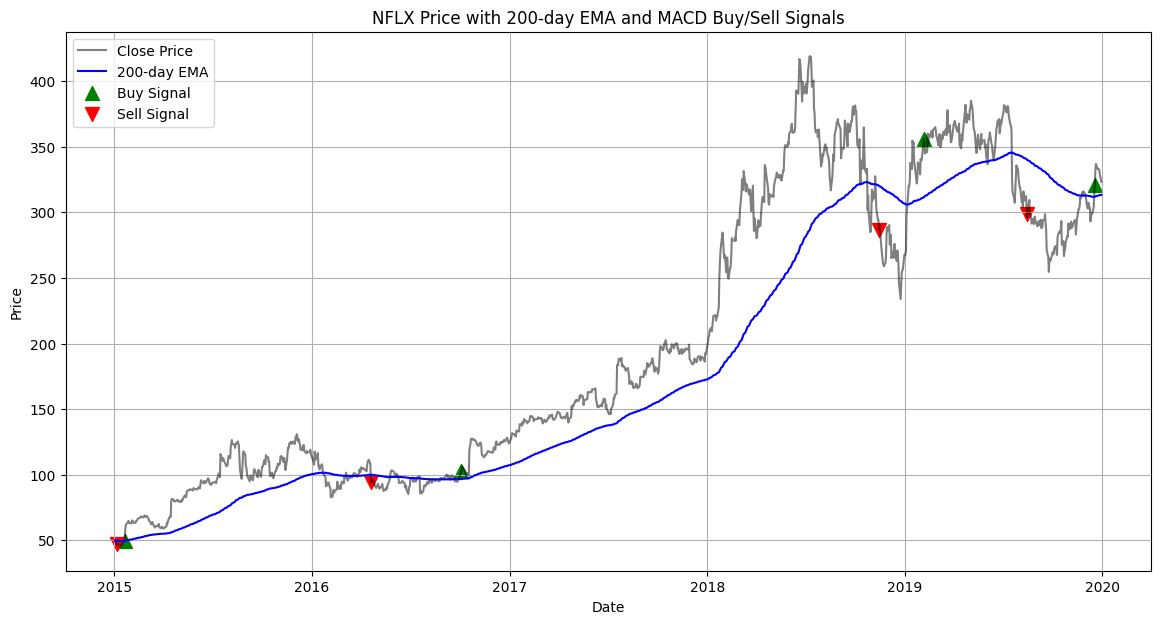

[*********************100%***********************]  5 of 5 completed


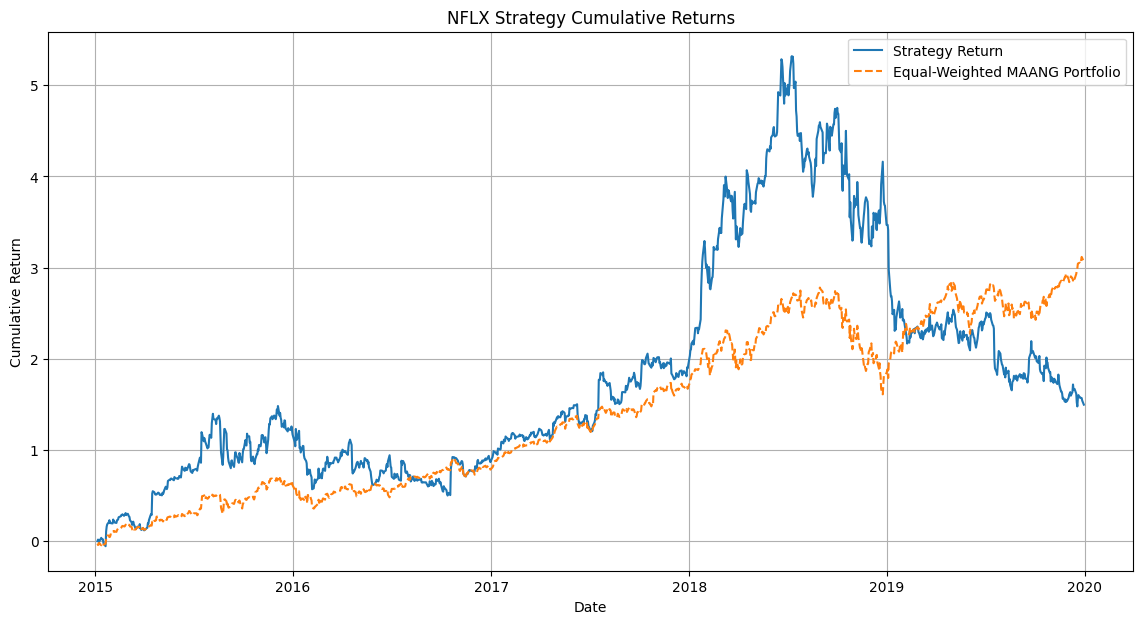

Performance Summary for NFLX:
Cumulative Strategy Return: 149.69%
Sharpe Ratio: 64.57%
Sortino Ratio: 100.61%
Treynor Ratio: 22.44%
Max Drawdown: -60.79%
Tracking Error: 36.18%
Information Ratio: -53.03%

=== Data for NFLX ===


,Close,EMA_200,MACD,Signal_Line,Position,Stock_Return,Strategy_Return,Cumulative_Strategy_Return,Benchmark_Cumulative_Returns
Date,,,,,,,,,
2015-01-02,49.848572,49.848572,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,47.311428,49.823327,-0.202393,-0.040479,-1,-0.050897,-0.000000,0.000000,-0.026940
2015-01-06,46.501431,49.790273,-0.423272,-0.117037,-1,-0.017121,0.017121,0.017121,-0.042122
2015-01-07,46.742859,49.759950,-0.572243,-0.208078,-1,0.005192,-0.005192,0.011840,-0.036974
2015-01-08,47.779999,49.740249,-0.599701,-0.286403,-1,0.022188,-0.022188,-0.010611,-0.018178
...,...,...,...,...,...,...,...,...,...
2019-12-23,333.100006,312.562129,8.188670,5.255982,1,-0.011279,-0.011279,1.572546,3.053787
2019-12-24,333.200012,312.767482,8.832670,5.971319,1,0.000300,0.000300,1.573319,3.045198
2019-12-26,332.630005,312.965119,9.191100,6.615276,1,-0.001711,-0.001711,1.568917,3.117227


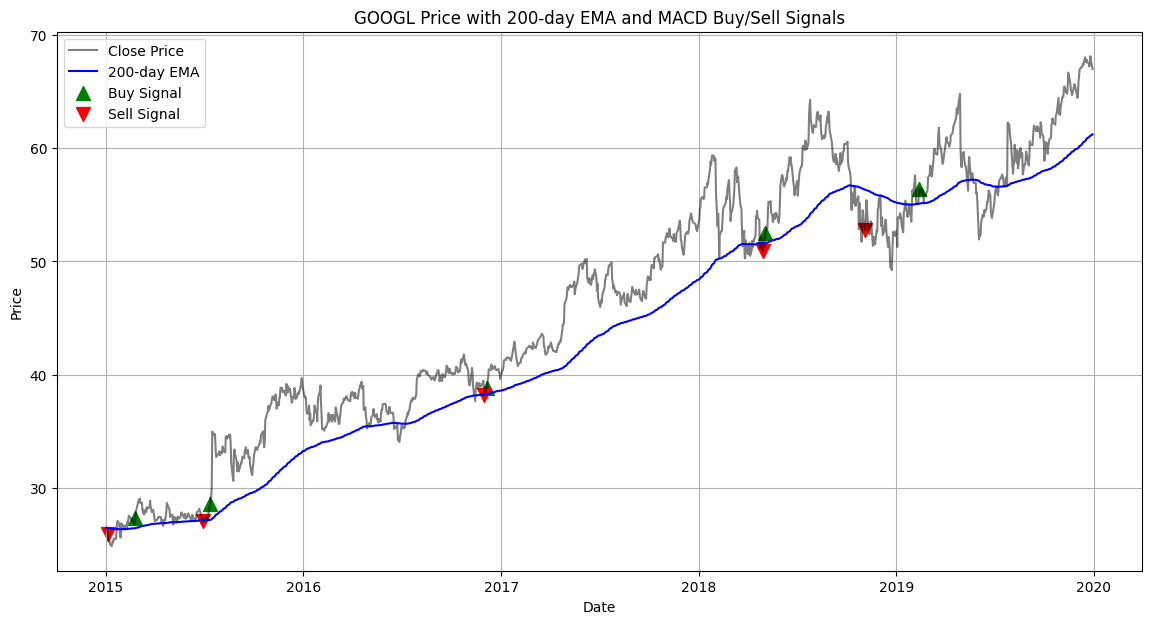

[*********************100%***********************]  5 of 5 completed


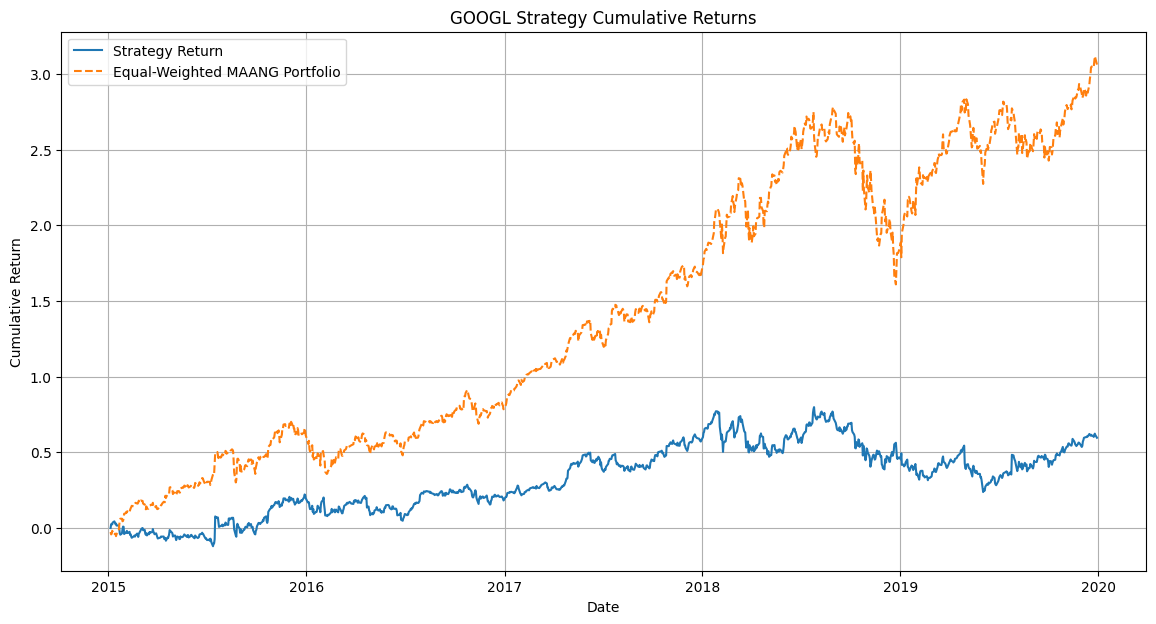

Performance Summary for GOOGL:
Cumulative Strategy Return: 59.65%
Sharpe Ratio: 51.26%
Sortino Ratio: 71.01%
Treynor Ratio: 10.16%
Max Drawdown: -31.19%
Tracking Error: 17.59%
Information Ratio: -52.49%

=== Data for GOOGL ===


,Close,EMA_200,MACD,Signal_Line,Position,Stock_Return,Strategy_Return,Cumulative_Strategy_Return,Benchmark_Cumulative_Returns
Date,,,,,,,,,
2015-01-02,26.477501,26.477501,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,25.973000,26.472481,-0.040245,-0.008049,-1,-0.019054,-0.000000,0.000000,-0.026940
2015-01-06,25.332001,26.461133,-0.122451,-0.030929,-1,-0.024679,0.024679,0.024679,-0.042122
2015-01-07,25.257500,26.449156,-0.191406,-0.063025,-1,-0.002941,0.002941,0.027693,-0.036974
2015-01-08,25.345501,26.438175,-0.236228,-0.097665,-1,0.003484,-0.003484,0.024112,-0.018178
...,...,...,...,...,...,...,...,...,...
2019-12-23,67.531502,60.958881,0.832736,0.853264,1,-0.000437,-0.000437,0.609483,3.053787
2019-12-24,67.221497,61.021195,0.767544,0.836120,1,-0.004591,-0.004591,0.602095,3.045198
2019-12-26,68.123497,61.091865,0.779675,0.824831,1,0.013418,0.013418,0.623593,3.117227


In [48]:
# stocks = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
# for stock in stocks:
#     strategy = TradingStrategy(stock, '2015-01-01', '2019-12-31')
    
#     strategy.calculate_indicators()
#     strategy.generate_signals()
#     strategy.calculate_returns()
#     strategy.cumulative_return()
#     strategy.sharpe_ratio()
#     strategy.sortino_ratio()
#     strategy.treynor_ratio(beta=1.2)  # Assuming beta = 1.2 for simplicity
#     strategy.max_drawdown()
#     strategy.tracking_error()
#     strategy.information_ratio()
#     strategy.visualize_signals()
#     strategy.plot_cumulative_returns()
#     strategy.summary()

#     print(f"\n=== Data for {stock} ===")
#     display(strategy.data)

stocks = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
for stock in stocks:
    # Download data and initialize performance metrics dictionary
    data = download_data(stock, '2015-01-01', '2019-12-31')
    performance_metrics = {}

    # Calculate indicators and signals
    calculate_indicators(data)
    generate_signals(data)
    calculate_returns(data)

    # Visualize signals and strtegy returns
    visualize_signals(data, stock)
    
# Calculate performance metrics
performance_metrics['Cumulative Strategy Return'] = final_cumulative_return(data)
performance_metrics['Sharpe Ratio'] = sharpe_ratio(data)
performance_metrics['Sortino Ratio'] = sortino_ratio(data)
performance_metrics['Treynor Ratio'] = treynor_ratio(data, beta=1.2)
performance_metrics['Max Drawdown'] = max_drawdown(data)
performance_metrics['Tracking Error'] = tracking_error(data)
performance_metrics['Information Ratio'] = information_ratio(data)

# Visualize signals and cumulative returns
plot_cumulative_returns(data, stock, '2015-01-01', '2019-12-31')
    
# Print the summary
summary(stock, data, performance_metrics)

print(f"\n=== Data for {stock} ===")
display(data)